# Notebook 3: Modelling 

In [1]:
import json
import os
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("custom_ggplot")
import matplotlib.ticker as mtick
from tqdm import tqdm

import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [2]:
WYSCOUT_DATA_FOLDER = "../wyscout_figshare_data" ## path where the wyscout data is extracted

df = pd.read_csv("../final_processed_data.csv")

with open(os.path.join(WYSCOUT_DATA_FOLDER, 'teams.json')) as f:
    teams_meta = json.load(f)
team_names_dict = {t['wyId']:t['name'] for t in teams_meta}

p = df.groupby(["matchId", "teamId", "minutes_remaining"]).agg(
    score_differential =("score_differential", "last"), 
    goals_scored = ("goals_scored", "last"), 
    player_differential = ("player_differential", "last"), 
    own_yellow_cards = ("own_yellow_cards", "last"), 
    opposition_yellow_cards = ("opposition_yellow_cards", "last"), 
    is_home_team = ("is_home_team", "last"), 
    avg_team_xt = ("avg_team_xt", "last"), 
    avg_opp_xt = ("avg_opp_xt", "last"), 
    running_xt_differential = ("running_xt_differential", "mean"), 
    scored_goal_after = ("scored_goal_after", "last"), 
    time_interval=('time_interval', 'last')
).reset_index().sort_values(['matchId', 'time_interval'])

print(df.shape)
print(p.shape)

(578304, 38)
(63437, 14)


In [3]:
p.head()

,matchId,teamId,minutes_remaining,score_differential,goals_scored,player_differential,own_yellow_cards,opposition_yellow_cards,is_home_team,avg_team_xt,avg_opp_xt,running_xt_differential,scored_goal_after,time_interval
90,2499759,1651,95,0,0,0,0,0,0,1.493016,1.370667,0.001277,0.010101,1
183,2499759,1659,95,0,0,0,0,0,1,1.370667,1.493016,-0.000255,0.020202,1
89,2499759,1651,94,0,0,0,0,0,0,1.493016,1.370667,0.001245,0.010204,2
182,2499759,1659,94,0,0,0,0,0,1,1.370667,1.493016,-0.001384,0.020408,2
88,2499759,1651,93,0,0,0,0,0,0,1.493016,1.370667,-0.001422,0.010309,3


In [4]:
holdout_match_ids = [2500098]

In [5]:
cols =  [
    'goals_scored',
    'player_differential', 
    'own_yellow_cards', 
    'opposition_yellow_cards', 
    'is_home_team',
    'avg_team_xt', 
    'avg_opp_xt', 
    'time_interval', 
    'running_xt_differential',
    'score_differential'
]

features = [
    'goals_scored',
    'player_differential', 
    'own_yellow_cards', 
    'opposition_yellow_cards', 
    'is_home_team',
    'avg_team_xt', 
    'avg_opp_xt', 
    'running_xt_differential',
    'score_differential'
]

target = 'scored_goal_after'

X_train, X_test, y_train, y_test = train_test_split(p.query("matchId != @holdout_match_ids")[cols], 
                                                    p.query("matchId != @holdout_match_ids")[target], 
                                                    test_size=0.2, random_state=42
                                                   )
model = lgb.LGBMRegressor()
model.fit(X_train[features], y_train, 
          eval_set=[(X_test[features], y_test)], early_stopping_rounds=200, 
          verbose=20
         )
predictions = model.predict(X_test[features])

Training until validation scores don't improve for 200 rounds
[20]	valid_0's l2: 0.000354763
[40]	valid_0's l2: 0.000298449
[60]	valid_0's l2: 0.000267932
[80]	valid_0's l2: 0.000245506
[100]	valid_0's l2: 0.000226545
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.000226545


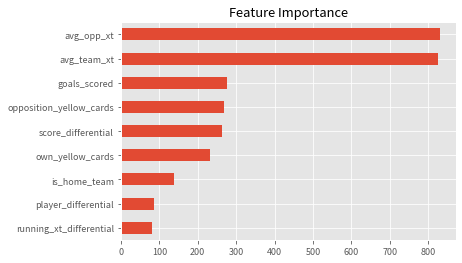

In [6]:
(pd.Series(model.feature_importances_, index=features)
 .sort_values()
   .plot(kind='barh', title='Feature Importance'));

The most important features seem to be the pre-match team strength indicators - `avg_team_xt` & `avg_opp_xt` - which does make sense. Remember, at this point we are not trying to predict the win probability but simply the probability of the teams scoring in the remaining time intervals. Using the model predicted probabilities to simulate and calculate the win probability comes next. 

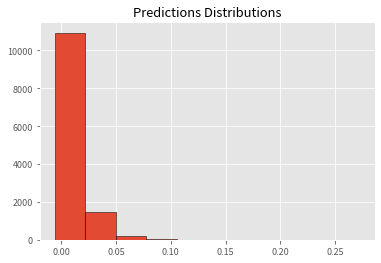

In [7]:
plt.hist(model.predict(X_test[features]), ec='k') 
plt.title('Predictions Distributions');

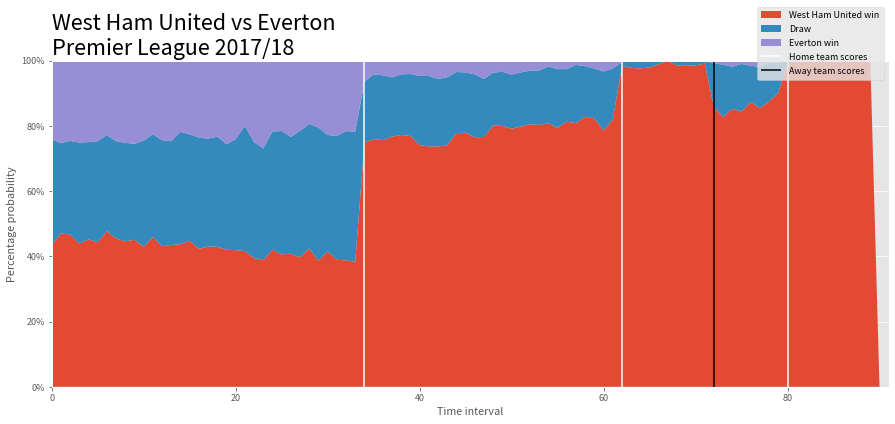

In [8]:
n_sims = 1000 ## number of simulations for each remaining time interval
fig, axes = plt.subplots(figsize=(15, 6), sharey=True)

for holdout_match_id, ax in zip(holdout_match_ids, [axes]):
    holdout = p.query("matchId == @holdout_match_id").copy()
    holdout["team_scoring_prob"] = model.predict(holdout[features])

    home_team_id = holdout.query("is_home_team == 1").teamId.unique()[0]
    away_team_id = holdout.query("is_home_team == 0").teamId.unique()[0]
    h = holdout.pivot_table(index='time_interval', 
                            columns='teamId', 
                            values=['team_scoring_prob', 'score_differential']).reset_index()
    h.columns = [a+"_"+str(b) for (a,b) in h.columns]
    h = h.reset_index(drop=True)
    
    for idx in h[h.isnull().any(axis=1)].index:
        if h.loc[idx, f"score_differential_{home_team_id}"] != h.loc[idx, f"score_differential_{home_team_id}"]:
            h.loc[idx, f"score_differential_{home_team_id}"] = -h.loc[idx, f"score_differential_{away_team_id}"]
            
        elif h.loc[idx, f"score_differential_{away_team_id}"] != h.loc[idx, f"score_differential_{away_team_id}"]:
            h.loc[idx, f"score_differential_{away_team_id}"] = -h.loc[idx, f"score_differential_{home_team_id}"]
            
    h = h.fillna(0)
    home_wins_list = []
    away_wins_list = []
    draws_list = []

    for time_interval, hsd, asd, h_prob, a_prob in zip(h["time_interval_"], 
                                               h[f"score_differential_{home_team_id}"], 
                                               h[f"score_differential_{away_team_id}"], 
                                               h[f"team_scoring_prob_{home_team_id}"], 
                                               h[f"team_scoring_prob_{away_team_id}"]):
        if time_interval != 100:

            home_goals_sim = np.random.binomial(100-time_interval, h_prob, n_sims)
            away_goals_sim = np.random.binomial(100-time_interval, a_prob, n_sims)
            
            home_sd_sim = hsd + (home_goals_sim - away_goals_sim)

            home_wins = np.sum(home_sd_sim > 0)
            away_wins = np.sum(home_sd_sim < 0)
            draws = np.sum(home_sd_sim == 0)

            home_wins_list.append((home_wins/n_sims)*100)
            away_wins_list.append((away_wins/n_sims)*100)
            draws_list.append((draws/n_sims)*100)
            
        else:
            
            home_wins_list.append(0)
            away_wins_list.append(0)
            draws_list.append(0)

    y = np.vstack([home_wins_list, draws_list, away_wins_list])
    
    ax.stackplot(range(len(home_wins_list)), 
                 y, 
                 labels=[f"{team_names_dict[home_team_id]} win", "Draw", f"{team_names_dict[away_team_id]} win"]
                )
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    draw_home_goals = draw_away_goals = True
    for (idx, val) in h.loc[(h[f"score_differential_{home_team_id}"].diff()!=0), f"score_differential_{home_team_id}"].diff().dropna().iteritems():
        if val == 1:
            if draw_home_goals:
                draw_home_goals = False
                hlabel = "Home team scores"
            else:
                hlabel = None
            ax.vlines(idx, 0, 100, color=['white'], label=hlabel)
        elif val == -1:
            if draw_away_goals:
                alabel = "Away team scores"
                draw_away_goals = False
            else:
                alabel = None
            ax.vlines(idx, 0, 100, color=['black'], label=alabel)
    
    ## plot cosmetics
    
    ax.set(xlabel = "Time interval", 
           ylabel= "Percentage probability",
           xlim=(0, len(home_wins_list)),
           ylim=(0, 100)
          )
    
    ax.title.set(text=f"{team_names_dict[home_team_id]} vs {team_names_dict[away_team_id]}\nPremier League 2017/18",
                 fontsize=24, x=0, ha='left')

    ax.legend(loc=1, 
             bbox_to_anchor=(0.8, 0.98, 0.2, 0.2));
    # fig.savefig('test', dpi=200)

fig